In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from tqdm import tqdm # for progress bar
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Libraries for TensorFlow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import callbacks
# from livelossplot.inputs.keras import PlotLossesCallback

# Library for Transfer Learning
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import preprocess_input

In [2]:
# Load data
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

# Split validate set, training set, and test set
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

2023-05-08 22:35:44.365410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 22:35:45.171377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2631 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [3]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = callbacks.ModelCheckpoint(filepath='model/resnet_mnist.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

callbacks_def = [reduce_learning, eary_stopping, tl_checkpoint_1]

In [4]:
# Using pooling='average' in ResNet50()  => ACCURACY: 0.11 - Not improving 
head_model = Sequential()
head_model.add(ResNet50(include_top=False, weights='imagenet', input_shape = (32,32,3)))
for layer in head_model.layers:
  layer.trainable = False

head_model.add(layers.GlobalAveragePooling2D())
head_model.add(layers.Dense(1024, activation='relu'))
head_model.add(layers.Dropout(0.1))
head_model.add(layers.Dense(512, activation='relu'))
head_model.add(layers.Dropout(0.1))
head_model.add(layers.Dense(10, activation='softmax'))
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
head_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [5]:
# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))

# Train model
history = head_model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val), callbacks=callbacks_def)
# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))

Training started at %s Mon May  8 22:35:47 2023
Epoch 1/40


2023-05-08 22:35:53.928774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2023-05-08 22:35:56.395269: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 22:35:56.397271: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 22:35:56.397364: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-08 22:35:56.399419: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 22:35:56.399623: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  7/907 [..............................] - ETA: 17s - loss: 3.4891 - accuracy: 0.1451   

2023-05-08 22:35:57.122779: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:35:57.122857: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:35:57.143459: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:35:57.143552: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

907/907 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.7949

2023-05-08 22:36:12.332450: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:36:12.332553: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:36:12.365855: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:36:12.365967: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc


Epoch 1: val_loss improved from inf to 0.30819, saving model to model/resnet_mnist.weights.best.hdf5
907/907 [==============================] - 26s 19ms/step - loss: 0.6190 - accuracy: 0.7949 - val_loss: 0.3082 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 2/40
906/907 [============================>.] - ETA: 0s - loss: 0.3606 - accuracy: 0.8806
Epoch 2: val_loss improved from 0.30819 to 0.30221, saving model to model/resnet_mnist.weights.best.hdf5
907/907 [==============================] - 16s 17ms/step - loss: 0.3606 - accuracy: 0.8806 - val_loss: 0.3022 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 3/40
904/907 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8940
Epoch 3: val_loss improved from 0.30221 to 0.19804, saving model to model/resnet_mnist.weights.best.hdf5
907/907 [==============================] - 16s 18ms/step - loss: 0.3232 - accuracy: 0.8940 - val_loss: 0.1980 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 4/40
904/907 [============================>.] - ETA:

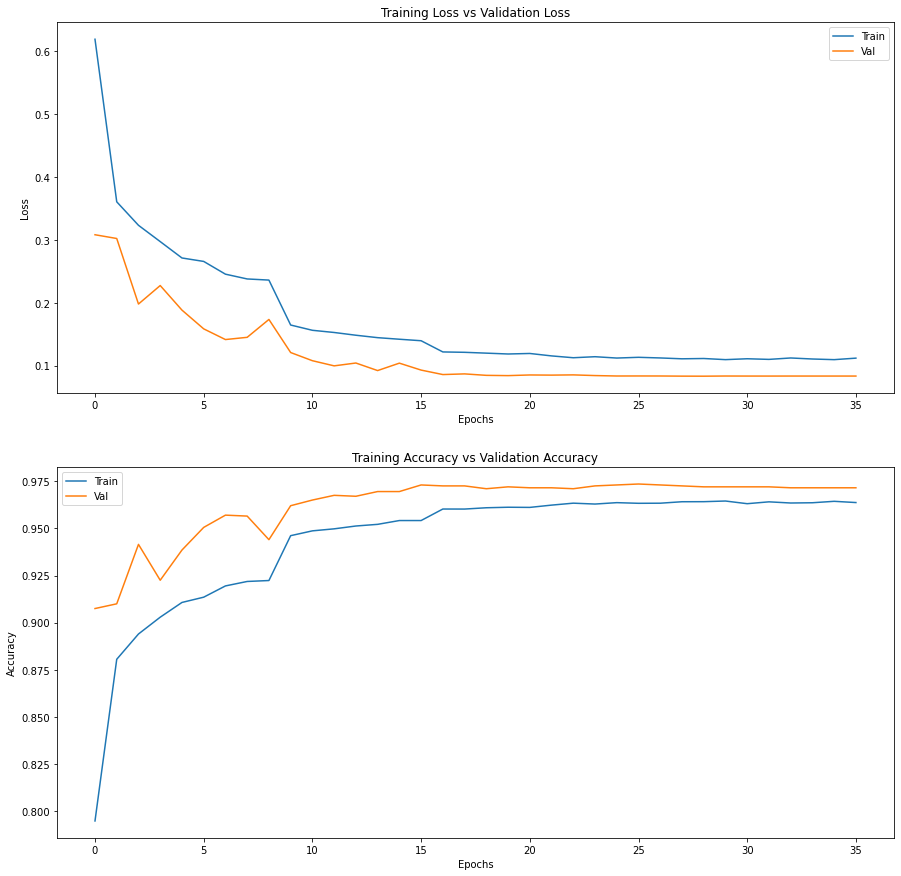

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [7]:
head_model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 15ms/step - loss: 0.1185 - accuracy: 0.9630


[0.1185326874256134, 0.9629999995231628]

In [8]:
models.save_model(head_model, 'model/resnet_mnist')

2023-05-08 22:45:14.743803: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/resnet_mnist/assets
